In [81]:
# IMPORT THE LIBRARY
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tempfile
from matplotlib import pyplot as plt

In [82]:
#Load the data
data_dir = "Tomato Leaf/train"

In [83]:
# Create a dataset
batch_size = 32 # batch size
img_height = 180 # image height
img_width = 180 # image width

# Create training dataset from images, validation split of 0.2 
train_ds = tf.keras.utils.image_dataset_from_directory( 
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Create validation dataset from images, validation split of 0.2
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123, # random seed for shuffling the dataset
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11921 files belonging to 5 classes.
Using 10729 files for training.
Found 11921 files belonging to 5 classes.
Using 1192 files for validation.


In [84]:
# Retrieve the class names from the train_ds dataset
class_names = train_ds.class_names
print(class_names) # print the class names

['Bacterial_spot', 'Early_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'powdery_mildew']


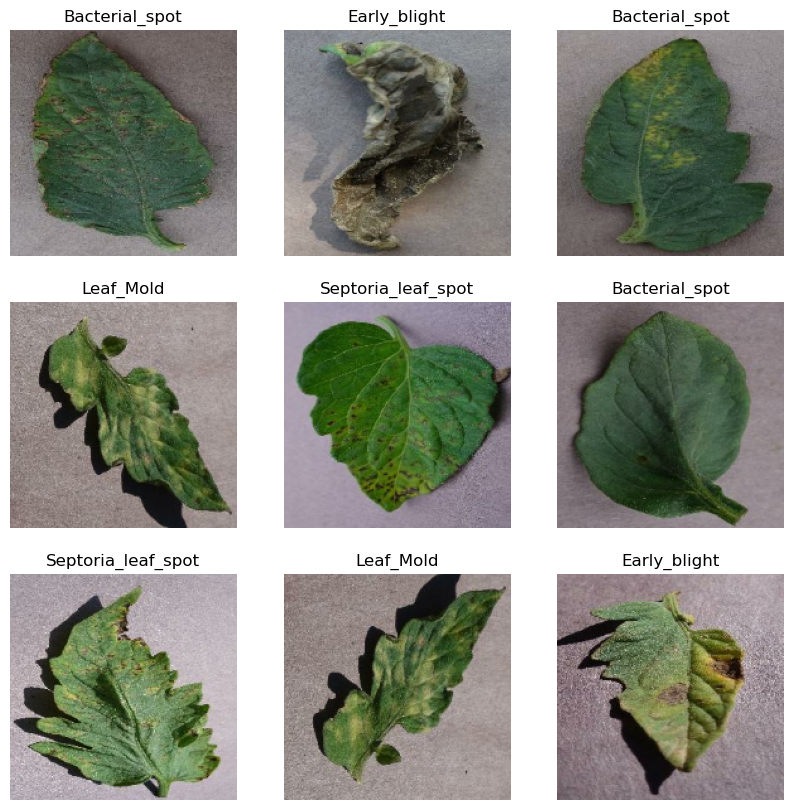

In [85]:
# Import the matplotlib library to plot
import matplotlib.pyplot as plt

# Create a figure with a size of 10x10
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # iterate over the first batch of images
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) # plot the figure
    plt.imshow(images[i].numpy().astype("uint8")) # show the figure
    plt.title(class_names[labels[i]]) # show the names for each figure
    plt.axis("off")

In [86]:
# Prints the shape of the image and label batches
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break # exit the loop after printing


(32, 180, 180, 3)
(32,)


In [87]:
# Optimizes data loading and training performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:

# Standardize the data
normalization_layer = layers.Rescaling(1./255)

In [95]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [96]:
num_classes = 5 # number of classes

# Create a sequential model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [97]:
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [98]:
# Model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [99]:
# Define a custom callback to track the learning rate
class LearningRateTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateTracker, self).__init__()
        self.learning_rates = []  # List to store learning rate values

    def on_epoch_end(self, epoch, logs=None):
        optimizer = self.model.optimizer
        learning_rate = tf.keras.backend.get_value(optimizer.lr)  # Get the learning rate
        self.learning_rates.append(learning_rate)  # Append the learning rate to the list

# Train and save the model
epochs = 10  # number of epochs
lr_tracker = LearningRateTracker()  # Create an instance of the custom callback
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_tracker]  # Pass the callback to track the learning rate
)

!mkdir -p saved_model
model.save('datatrain/saved_model/my_model') # save the model

# Calculate evaluation metrics
train_loss, train_accuracy = model.evaluate(train_ds)
val_loss, val_accuracy = model.evaluate(val_ds)

predictions = np.argmax(model.predict(val_ds), axis=-1)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

error_rate = 1 - np.mean(predictions == val_labels)
recall = tf.keras.metrics.Recall()(val_labels, predictions).numpy()
precision = tf.keras.metrics.Precision()(val_labels, predictions).numpy()

# Print the evaluation metrics
print("Accuracy Rate - Train: {:.4f}, Validation: {:.4f}".format(train_accuracy, val_accuracy))
print("Learning Rate: {:.6f}".format(lr_tracker.learning_rates[-1])) 
print("Error Rate: {:.4f}".format(error_rate))
print("Recall: {:.4f}".format(recall))
print("Precision: {:.4f}".format(precision))

Epoch 1/10
336/336 [==============================] - 93s 275ms/step - loss: 0.9678 - accuracy: 0.5987 - val_loss: 0.6628 - val_accuracy: 0.7357
Epoch 2/10
336/336 [==============================] - 92s 275ms/step - loss: 0.5912 - accuracy: 0.7714 - val_loss: 0.5833 - val_accuracy: 0.7718
Epoch 3/10
336/336 [==============================] - 92s 275ms/step - loss: 0.4269 - accuracy: 0.8368 - val_loss: 0.5264 - val_accuracy: 0.8045
Epoch 4/10
336/336 [==============================] - 94s 281ms/step - loss: 0.2883 - accuracy: 0.8923 - val_loss: 0.4524 - val_accuracy: 0.8314
Epoch 5/10
336/336 [==============================] - 96s 285ms/step - loss: 0.1850 - accuracy: 0.9342 - val_loss: 0.5732 - val_accuracy: 0.8322
Epoch 6/10
336/336 [==============================] - 90s 269ms/step - loss: 0.1447 - accuracy: 0.9525 - val_loss: 0.5943 - val_accuracy: 0.8138
Epoch 7/10
336/336 [==============================] - 89s 266ms/step - loss: 0.0868 - accuracy: 0.9745 - val_loss: 0.7189 - val_ac

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: datatrain/saved_model/my_model\assets


INFO:tensorflow:Assets written to: datatrain/saved_model/my_model\assets


38/38 [==============================] - 2s 51ms/step
Accuracy Rate - Train: 0.9946, Validation: 0.8507
Learning Rate: 0.001000
Error Rate: 0.1493
Recall: 0.9701
Precision: 0.9701


In [22]:
# Load the saved model and view the summary
new_model = tf.keras.models.load_model('datatrain/saved_model/my_model')
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

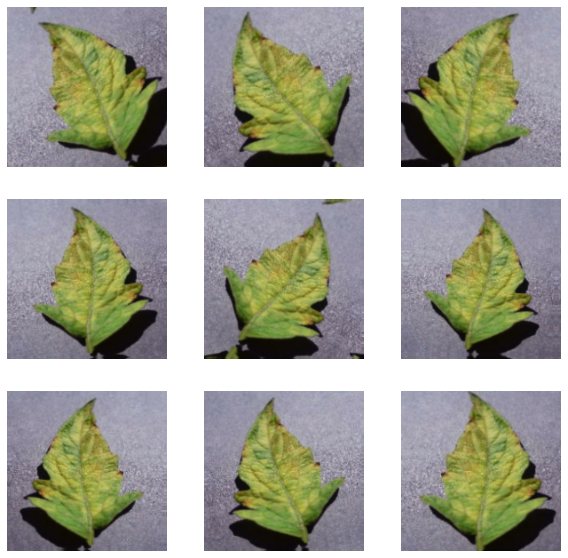

In [23]:
# Data augmentation using randomflip
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Display the figure
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
# Sequential model and its architecture 
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [26]:
# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [31]:
# Predict using the model that we train
img = tf.keras.utils.load_img(
    'Tomato Leaf/valid/powdery_mildew/powdery_mildew (10).JPG', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
) # print the result


1/1 [==============================] - 1s 579ms/step
This image most likely belongs to Early_blight with a 23.18 percent confidence.
